In [1]:
import pandas as pd
import json
import random
from collections import defaultdict
import os
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE


# Distance/Similarity calculation and clustering

In [2]:
folder_path = '/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/BindingSiteAnalysis/kras_md_sites_1'  # Replace with your actual folder path


In [3]:
all_binding_sites = []

for file_name in sorted(os.listdir(folder_path)):  
    if file_name.endswith('.pkl'):  
        file_path = os.path.join(folder_path, file_name)
        
        try:
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
            
            sites = data.get('sites', [])
            for site in sites:
                all_binding_sites.append(site)
        
        except Exception as e:
            print(f"Error loading {file_name}: {e}")

print(f"Total binding sites extracted: {len(all_binding_sites)}")

Total binding sites extracted: 60791


In [4]:
def residue_overlap_distance(site1, site2):
    residues1 = set(site1.get('residues', []))
    residues2 = set(site2.get('residues', []))
    
    if not residues1 or not residues2: 
        return 1.0 
    
    # Jaccard distance = 1 - Jaccard similarity
    return 1 - len(residues1 & residues2) / len(residues1 | residues2)

# Denominator can also be max. Maybe another parameter to the function. 

In [5]:
def pairwise_distances_with_library(sites, distance_func):
    def distance_wrapper(i, j):
        return distance_func(sites[int(i[0])], sites[int(j[0])])
    
    indices = list(range(len(sites)))
    condensed_matrix = pdist([[i] for i in indices], metric=lambda i, j: distance_wrapper(i, j))
    
    return squareform(condensed_matrix)


Processing pairwise distance for all sites in all frames was taking too long so taking a subset.

In [6]:
subset = all_binding_sites[:100]  # First 100 sites
distance_matrix = pairwise_distances_with_library(subset, residue_overlap_distance)

In [16]:
distance_matrix

array([[0.        , 0.85      , 0.41176471, ..., 0.62857143, 0.29411765,
        0.84615385],
       [0.85      , 0.        , 0.94736842, ..., 0.75757576, 0.84210526,
        0.5625    ],
       [0.41176471, 0.94736842, 0.        , ..., 0.71428571, 0.47058824,
        0.96153846],
       ...,
       [0.62857143, 0.75757576, 0.71428571, ..., 0.        , 0.57575758,
        0.58823529],
       [0.29411765, 0.84210526, 0.47058824, ..., 0.57575758, 0.        ,
        0.84      ],
       [0.84615385, 0.5625    , 0.96153846, ..., 0.58823529, 0.84      ,
        0.        ]])

In [18]:
len(distance_matrix)

100

## Agglomerative 

No. of clusters chosen using cut-off distance on the dendrogram.
(or we can specify with n parameter)

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


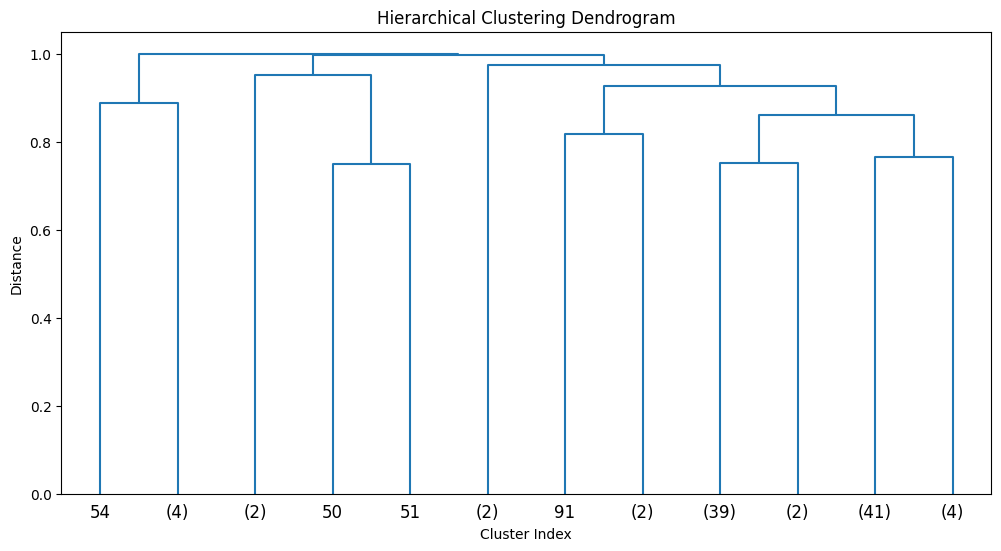

Number of clusters formed: 19


In [15]:
linkage_matrix = linkage(squareform(distance_matrix), method='average')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

clusters = fcluster(linkage_matrix, t=0.5, criterion='distance')
print(f"Number of clusters formed: {len(set(clusters))}")

In [23]:
clusters

array([ 9, 14,  9, 10, 14,  3,  6,  9,  7,  3,  6, 17,  9, 14,  7,  1, 15,
        9, 16, 14, 12,  9, 15,  9, 15, 10,  9, 15,  9, 15,  9, 15,  9, 15,
        9, 15,  9, 15,  9, 15,  9, 17,  9, 16,  9, 15,  9, 15,  9, 15,  4,
        5,  9, 15,  2,  9, 16, 14, 13,  9, 16,  9, 15,  9, 15,  9, 15,  9,
       14, 15, 19,  9, 15,  9, 15,  9, 15,  9, 15,  9, 15,  9, 15,  9, 15,
        1,  9, 16, 11,  1, 15,  8, 18, 15,  9, 15,  1, 15,  9, 15],
      dtype=int32)

In [11]:
from sklearn.cluster import AgglomerativeClustering


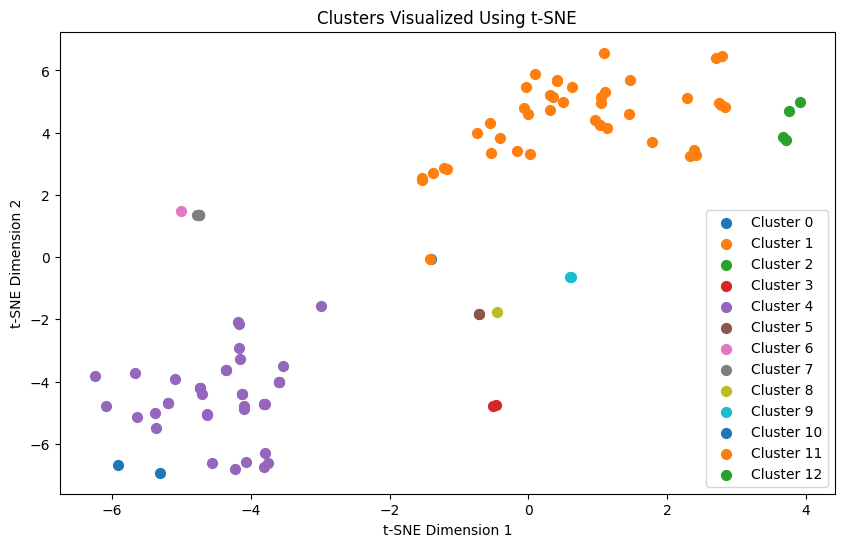

In [12]:
# Dimensionality reduction using t-SNE to visualise clusters in 2D
embedding = TSNE(n_components=2, metric='precomputed', init='random').fit_transform(distance_matrix)

agglom_model = AgglomerativeClustering(n_clusters=13, metric='precomputed', linkage='average')
cluster_labels = agglom_model.fit_predict(distance_matrix)

plt.figure(figsize=(10, 6))
for cluster_id in np.unique(cluster_labels):
    cluster_points = embedding[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', s=50)

plt.title('Clusters Visualized Using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

In [24]:
cluster_labels

array([ 4,  1,  4,  4,  1,  9,  3,  4,  5,  9,  3,  2,  4,  1,  5,  7,  1,
        4,  1,  1,  0,  4,  1,  4,  1,  4,  4,  1,  4,  1,  4,  1,  4,  1,
        4,  1,  4,  1,  4,  1,  4,  2,  4,  1,  4,  1,  4,  1,  4,  1, 11,
       10,  4,  1,  6,  4,  1,  1,  0,  4,  1,  4,  1,  4,  1,  4,  1,  4,
        1,  1, 12,  4,  1,  4,  1,  4,  1,  4,  1,  4,  1,  4,  1,  4,  1,
        7,  4,  1,  4,  7,  1,  8,  2,  1,  4,  1,  7,  1,  4,  1])

In [20]:
from collections import defaultdict


In [21]:
residue_mapping = [
    (site_index, residue_index)
    for site_index, site in enumerate(subset)
    for residue_index in range(len(site['residues']))
]

In [22]:
residue_mapping

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7),
 (7, 8),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (7, 15),
 (8, 0),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 8),
 (8, 9),
 (9, 0),
 (9, 1),
 (9, 2),
 (9, 3),
 (9, 4),
 (10, 0),
 (10, 1),
 (10, 2),
 (10, 3),
 (10, 4),
 (10, 5)

In [25]:
# Map cluster labels to residues
cluster_to_residues = defaultdict(list)
for idx, cluster_label in enumerate(cluster_labels):
    if cluster_label != -1:  # Ignore noise points (-1 in OPTICS/DBSCAN)
        site_idx, residue_idx = residue_mapping[idx]
        residue = subset[site_idx]['residues'][residue_idx]
        cluster_to_residues[cluster_label].append(residue)


In [26]:
for cluster, residues in cluster_to_residues.items():
    print(f"Cluster {cluster}:")
    for residue in residues:
        print(f"  - {residue}")

Cluster 4:
  - A_14_GLY
  - A_16_GLY
  - A_17_LYS
  - A_118_LYS
  - A_12_ALA
  - A_13_CYS
  - A_97_TYR
  - A_14_GLY
  - A_16_GLY
  - A_17_LYS
  - A_20_LEU
  - A_30_VAL
  - A_118_LYS
  - A_120_ASP
  - A_13_CYS
  - A_15_VAL
  - A_17_LYS
  - A_58_ASP
  - A_9_VAL
  - A_11_GLY
  - A_13_CYS
  - A_69_ARG
  - A_100_GLN
  - A_55_ASP
  - A_57_LEU
  - A_118_LYS
  - A_120_ASP
  - A_145_THR
  - A_151_GLN
  - A_15_VAL
  - A_17_LYS
  - A_29_PHE
  - A_118_LYS
  - A_147_ALA
  - A_18_SER
  - A_13_CYS
  - A_18_SER
  - A_38_GLU
  - A_7_LEU
Cluster 1:
  - A_15_VAL
  - A_19_ALA
  - A_13_CYS
  - A_12_ALA
  - A_17_LYS
  - A_59_THR
  - A_100_GLN
  - A_15_VAL
  - A_19_ALA
  - A_29_PHE
  - A_117_ASN
  - A_147_ALA
  - A_12_ALA
  - A_14_GLY
  - A_16_GLY
  - A_35_PRO
  - A_10_VAL
  - A_12_ALA
  - A_17_LYS
  - A_97_TYR
  - A_6_LYS
  - A_7_LEU
  - A_56_ILE
  - A_116_GLY
  - A_119_CYS
  - A_144_GLU
  - A_146_SER
  - A_147_ALA
  - A_14_GLY
  - A_16_GLY
  - A_19_ALA
  - A_117_ASN
  - A_120_ASP
  - A_148_LYS
  - A_20_LEU

## Mean-Shift

Identifies clusters by finding areas of high data density in the feature space.
Each data point starts as a candidate for the cluster center, then MeanShift calculates the mean of all data points within radius. Moves the candidate closer to the mean, repeating the process until convergence. Once all points are assigned to a peak, they are grouped together into clusters.

No. of clusters are not preset.

In [13]:
from sklearn.cluster import MeanShift

In [19]:
embedding = TSNE(n_components=2, metric='precomputed', init='random').fit_transform(distance_matrix)

mean_shift = MeanShift()
mean_shift_labels = mean_shift.fit_predict(embedding)

print("MeanShift Cluster Labels:", mean_shift_labels)

MeanShift Cluster Labels: [0 1 0 0 1 2 2 0 2 2 2 1 0 1 2 2 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 2 2 0 1 2 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 2 0 1 0 2 1 2 1 1 0 1 2 1 0 1]


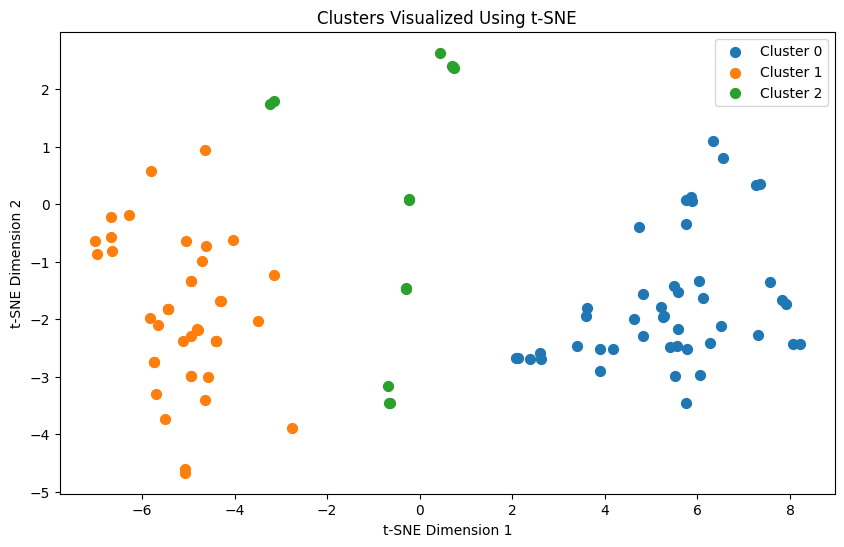

In [100]:

plt.figure(figsize=(10, 6))
for cluster_id in np.unique(mean_shift_labels):
    cluster_points = embedding[mean_shift_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', s=50)

plt.title('Clusters Visualized Using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

## OPTICS

Similar to DBSCAN. Groups points close together into clusters based on minimum density threshold ( parameters – min_samples and min_cluster_size).

In [33]:
from sklearn.cluster import OPTICS

Does not directly output clusters but instead shows a reachability plot - plot of reachability distance (smallest distance needed to reach a point from another dense region) versus order of each data point) . Clusters are determined by identifying valleys in the reachability plot.


OPTICS Cluster Labels: [-1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1  0  1 -1
  1 -1  0  1 -1  1  0  1 -1  1 -1  1  0  1 -1  1 -1 -1 -1 -1  0  1  0  1
 -1  1 -1 -1  0  1 -1 -1 -1 -1 -1 -1 -1  0  1  0  1 -1 -1 -1 -1 -1 -1 -1
  1 -1  1 -1  1 -1  1 -1  1  0 -1 -1 -1 -1  0  1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1  1]


/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/.venv/lib/python3.11/site-packages/sklearn/cluster/_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


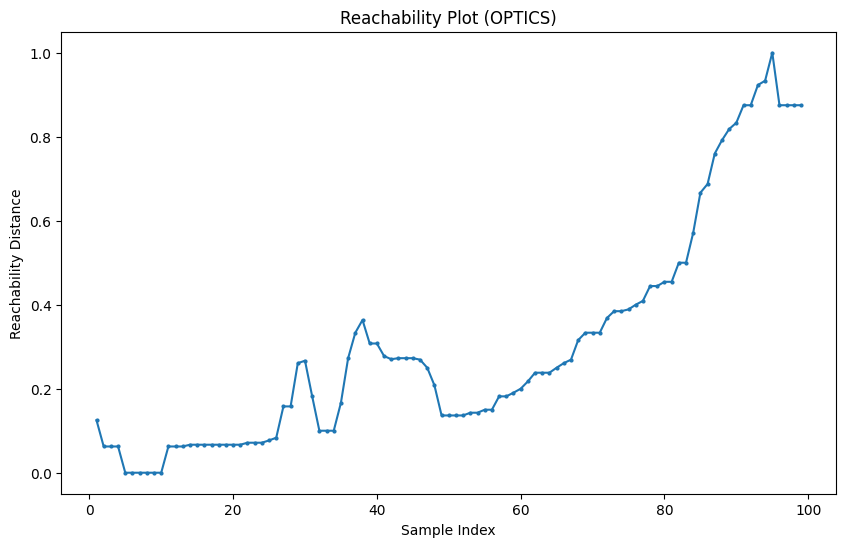

In [105]:
optics = OPTICS(metric='precomputed', min_samples=5, xi=0.05, min_cluster_size=0.1)
optics_labels = optics.fit_predict(distance_matrix)

print("OPTICS Cluster Labels:", optics_labels)

plt.figure(figsize=(10, 6))
plt.plot(optics.reachability_[optics.ordering_], marker='o', linestyle='-', markersize=2)
plt.title('Reachability Plot (OPTICS)')
plt.xlabel('Sample Index')
plt.ylabel('Reachability Distance')
plt.show()

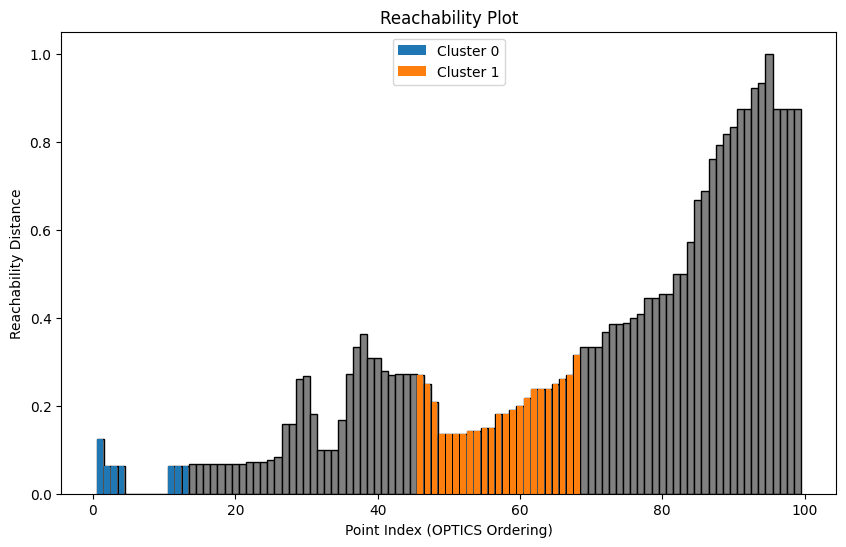

In [106]:
reachability = optics.reachability_[optics.ordering_]  
labels = optics.labels_[optics.ordering_]  
x = np.arange(len(reachability))  

plt.figure(figsize=(10, 6))
plt.bar(x, reachability, color='gray', edgecolor='k', width=1.0)
for cluster_label in np.unique(labels):
    if cluster_label != -1:  
        plt.bar(x[labels == cluster_label], reachability[labels == cluster_label], label=f'Cluster {cluster_label}')
plt.xlabel('Point Index (OPTICS Ordering)')
plt.ylabel('Reachability Distance')
plt.title('Reachability Plot')
plt.legend()
plt.show()

x-Axis is order of points processed by OPTICS. Clusters appear as valleys, peaks indicate boundaries between clusters.

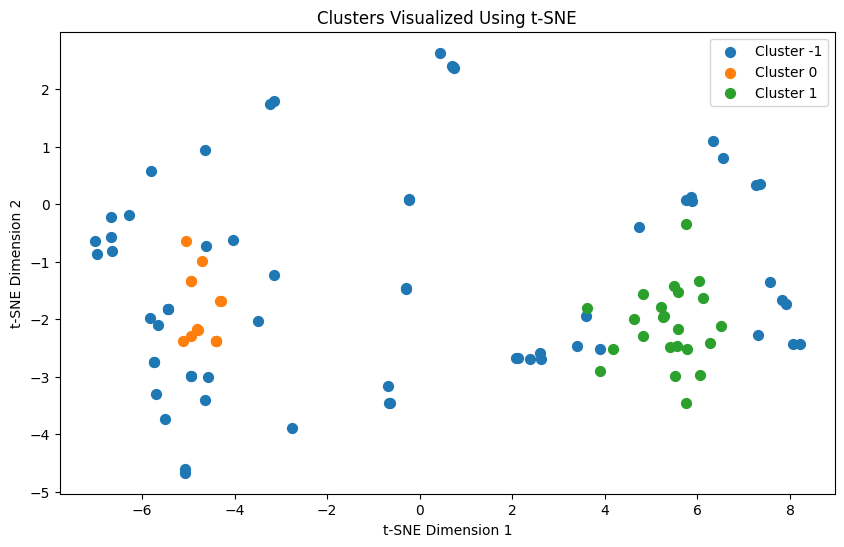

In [107]:

plt.figure(figsize=(10, 6))
for cluster_id in np.unique(optics_labels):
    cluster_points = embedding[optics_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', s=50)

plt.title('Clusters Visualized Using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

In [91]:
optics = OPTICS(metric='precomputed', min_samples=3, xi=0.01, min_cluster_size=0.05)
optics_labels = optics.fit_predict(distance_matrix)
print("OPTICS Labels:", optics_labels)

OPTICS Labels: [-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1  0  2  1
  2 -1  0  2  1 -1 -1  2 -1  2 -1  2  0  2 -1  2 -1 -1 -1 -1  0 -1 -1  2
 -1  2 -1  3 -1  2 -1 -1 -1 -1 -1 -1 -1 -1  2  0  2  1 -1 -1 -1 -1 -1 -1
 -1 -1  2  1  2 -1  2 -1 -1  0 -1  1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1 -1  2
 -1 -1 -1  2 -1 -1  1 -1  3 -1  3 -1 -1  1 -1 -1  0  2  3 -1 -1 -1  2 -1
  2 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  0  2  3  1 -1 -1 -1 -1 -1  2 -1 -1 -1
 -1 -1  0  2 -1  3 -1 -1 -1 -1  2 -1 -1  3 -1 -1 -1  3 -1 -1  3 -1  2  3
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2  3 -1 -1 -1 -1  0  2
  3 -1 -1 -1 -1  2  1 -1 -1 -1 -1 -1 -1  0 -1  1 -1  1 -1  1 -1 -1  0 -1
 -1  0 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1  3 -1 -1 -1 -1 -1 -1 -1  3 -1
 -1  2 -1  3 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1  0 -1  1  2 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1]


/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/.venv/lib/python3.11/site-packages/sklearn/cluster/_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [92]:
print("Distance Matrix Stats:")
print("Min:", np.min(distance_matrix))
print("Max:", np.max(distance_matrix))
print("Mean:", np.mean(distance_matrix))
print("Standard Deviation:", np.std(distance_matrix))

Distance Matrix Stats:
Min: 0.0
Max: 1.0
Mean: 0.7551238971082316
Standard Deviation: 0.26531007106730164


## DBSCAN

No. of clusters determined automatically based on eps parameter and min_samples parameter

In [45]:
from sklearn.cluster import DBSCAN

In [113]:
dbscan = DBSCAN(metric='precomputed', eps=0.5, min_samples=2)
labels = dbscan.fit_predict(distance_matrix)

unique_labels = set(labels)
print(f"Number of clusters (excluding noise): {len(unique_labels) - (1 if -1 in unique_labels else 0)}")
print(f"Noise points: {list(labels).count(-1)}")

Number of clusters (excluding noise): 5
Noise points: 6


In [109]:
labels

array([ 0,  0,  0,  0,  0,  1,  2,  0,  3,  1,  2,  0,  0,  0,  3,  4,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
       -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        4,  0,  0,  0,  4,  0, -1,  0,  0,  0,  0,  4,  0,  0,  0])

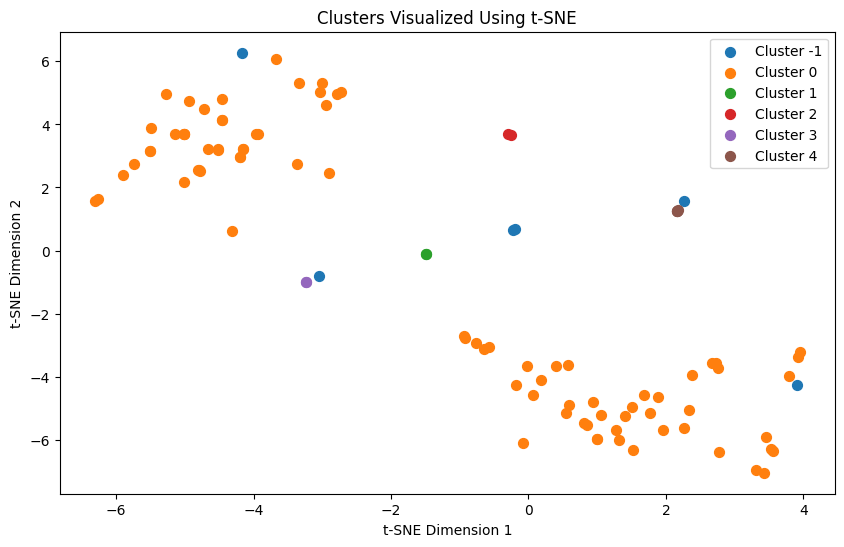

In [115]:
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(labels):
    cluster_points = embedding[labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', s=50)

plt.title('Clusters Visualized Using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

# Clustering based on residue scores


In [116]:
def residue_score_distance(site1, site2):
    scores1 = site1.get('residue_scores', {})
    scores2 = site2.get('residue_scores', {})
    
    common_residues = set(scores1.keys()) & set(scores2.keys())
    if not common_residues:
        return 10.0 
    
    return sum(abs(scores1[res] - scores2[res]) for res in common_residues) / len(common_residues)

In [117]:
distance_matrix_scores = pairwise_distances_with_library(subset, residue_score_distance)

In [67]:
# Verify that all distances are finite
if not np.all(np.isfinite(distance_matrix_scores)):
    print("Non-finite values found in distance matrix!")

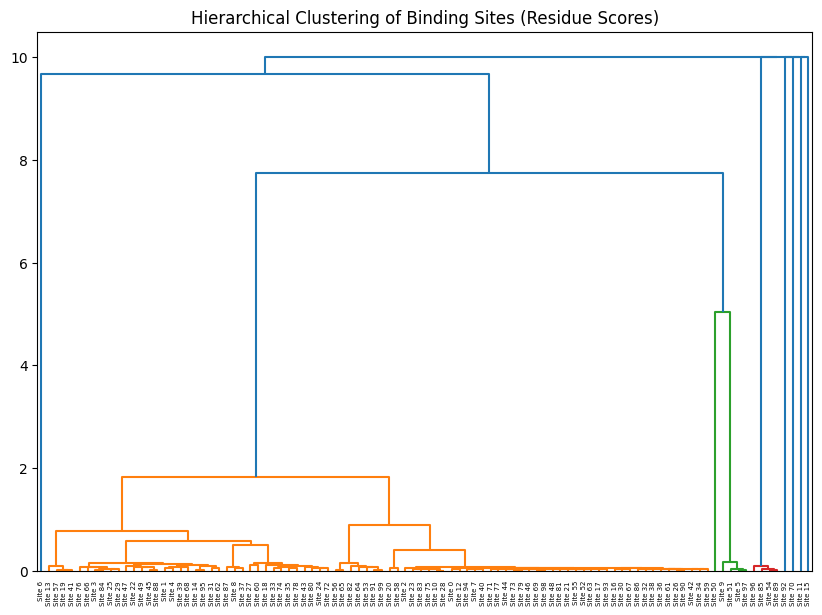

In [120]:
# Linkage matrix for hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix_scores), method='average')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=[f"Site {i}" for i in range(len(subset))])
plt.title("Hierarchical Clustering of Binding Sites (Residue Scores)")
plt.show()

In [121]:
clusters = fcluster(linkage_matrix, t=0.7, criterion='distance')
print(f"Number of clusters formed: {len(set(clusters))}")

Number of clusters formed: 12


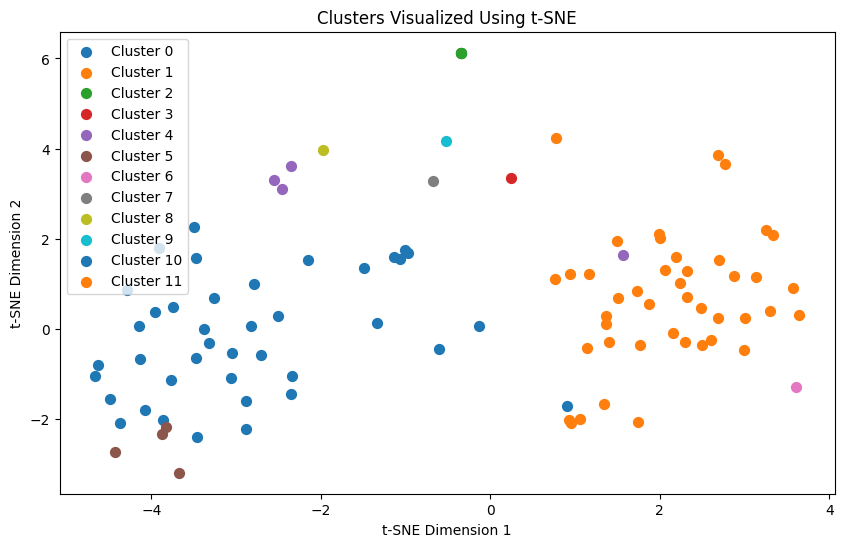

In [124]:
# Dimensionality reduction using t-SNE to visualise clusters in 2D
embedding = TSNE(n_components=2, metric='precomputed', init='random').fit_transform(distance_matrix_scores)

agglom_model = AgglomerativeClustering(n_clusters=12, metric='precomputed', linkage='average')
cluster_labels = agglom_model.fit_predict(distance_matrix_scores)

plt.figure(figsize=(10, 6))
for cluster_id in np.unique(cluster_labels):
    cluster_points = embedding[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', s=50)

plt.title('Clusters Visualized Using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

In [10]:
from sklearn.cluster import AgglomerativeClustering


In [ ]:
# n_clusters = 5  # Choose the number of clusters
# clustering = AgglomerativeClustering(
#     n_clusters=n_clusters,
#     metric='precomputed',   
#     linkage='average'
# ).fit(distance_matrix_scores)

# # Cluster labels
# cluster_labels = clustering.labels_
# print("Cluster labels:", cluster_labels)

Cluster labels: [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 0 1 1 1 2 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


## Meanshift

In [ ]:
embedding = TSNE(n_components=2, metric='precomputed', init='random').fit_transform(distance_matrix_scores)


mean_shift = MeanShift()
mean_shift_labels = mean_shift.fit_predict(embedding)


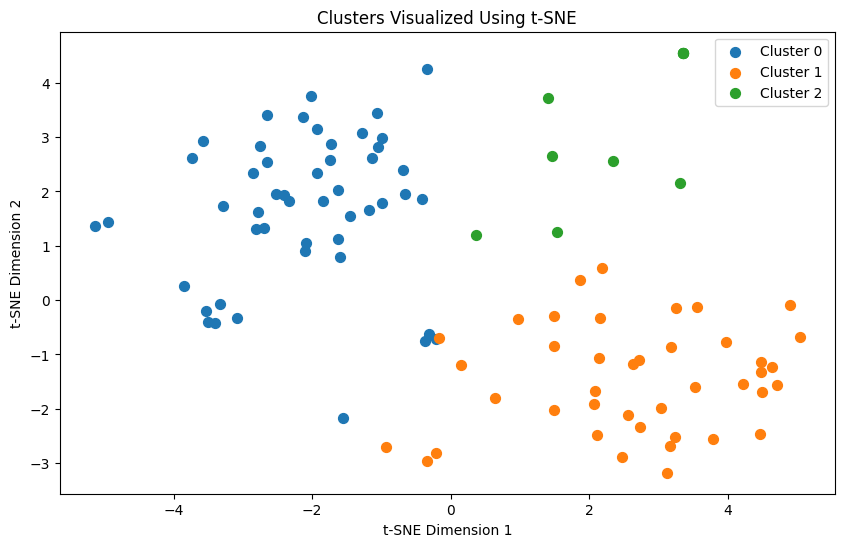

In [126]:
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(mean_shift_labels):
    cluster_points = embedding[mean_shift_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', s=50)

plt.title('Clusters Visualized Using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

## OPTICS

OPTICS Cluster Labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1 -1 -1  0 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1]


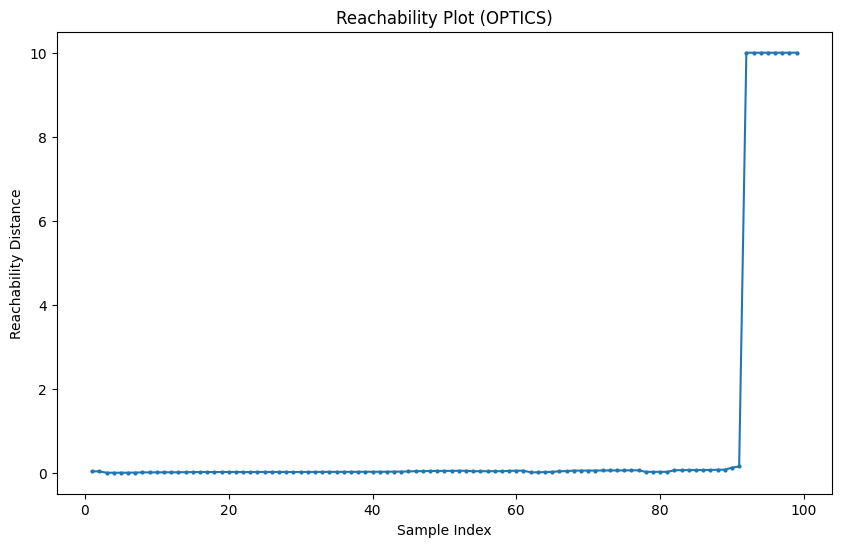

In [130]:
optics = OPTICS(metric='precomputed', min_samples=5, xi=0.05, min_cluster_size=0.1)
optics_labels = optics.fit_predict(distance_matrix_scores)

print("OPTICS Cluster Labels:", optics_labels)


plt.figure(figsize=(10, 6))
plt.plot(optics.reachability_[optics.ordering_], marker='o', linestyle='-', markersize=2)
plt.title('Reachability Plot (OPTICS)')
plt.xlabel('Sample Index')
plt.ylabel('Reachability Distance')
plt.show()

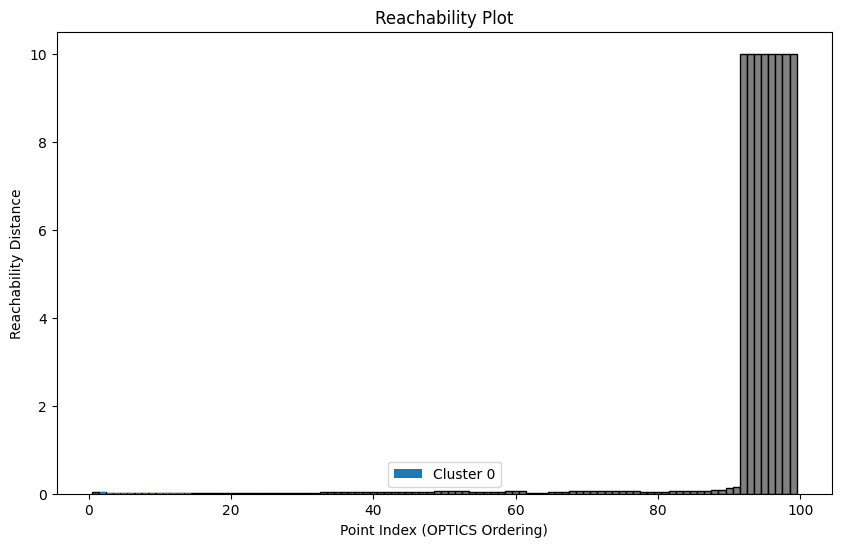

In [128]:
reachability = optics.reachability_[optics.ordering_]   
labels = optics.labels_[optics.ordering_]  
x = np.arange(len(reachability))  

plt.figure(figsize=(10, 6))
plt.bar(x, reachability, color='gray', edgecolor='k', width=1.0)
for cluster_label in np.unique(labels):
    if cluster_label != -1:  # Ignore noise points
        plt.bar(x[labels == cluster_label], reachability[labels == cluster_label], label=f'Cluster {cluster_label}')
plt.xlabel('Point Index (OPTICS Ordering)')
plt.ylabel('Reachability Distance')
plt.title('Reachability Plot')
plt.legend()
plt.show()

## DBSCAN

In [132]:
# Perform DBSCAN clustering
dbscan = DBSCAN(metric='precomputed', eps=0.5, min_samples=2)
labels = dbscan.fit_predict(distance_matrix_scores)

# Analyze clusters
unique_labels = set(labels)
print(f"Number of clusters (excluding noise): {len(unique_labels) - (1 if -1 in unique_labels else 0)}")
print(f"Noise points: {list(labels).count(-1)}")

Number of clusters (excluding noise): 2
Noise points: 4


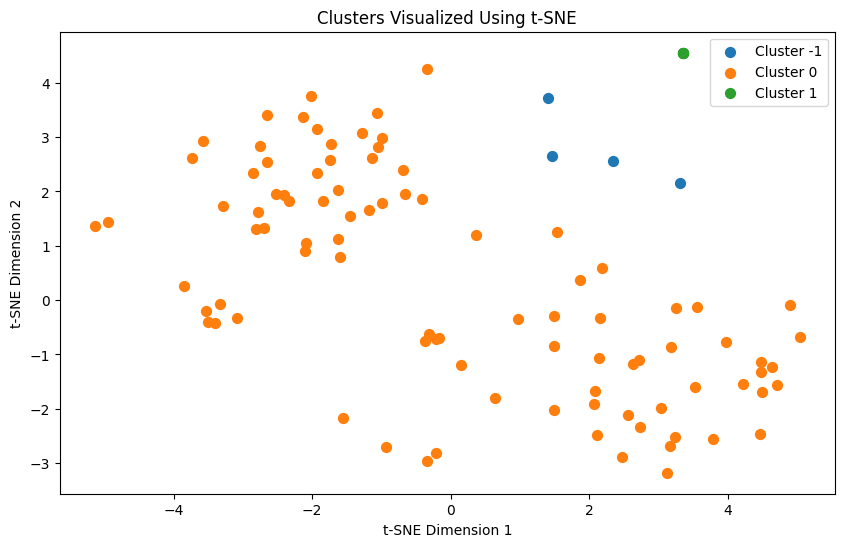

In [133]:
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(labels):
    cluster_points = embedding[labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', s=50)

plt.title('Clusters Visualized Using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

#### Clustering based on distance vectors from hotspots to residues/atoms


In [ ]:
all_binding_sites = []
all_target_data = []

for file_name in sorted(os.listdir(folder_path)):   
    if file_name.endswith('.pkl'):   
        file_path = os.path.join(folder_path, file_name)
        
        try:
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
            
            sites = data.get('sites', [])
            for site in sites:
                all_binding_sites.append({'file': file_name, 'site': site})  
        
            target = data.get('target', {})
            if target:
                all_target_data.append({'file': file_name, 'target': target}) 
        
        except Exception as e:
            print(f"Error loading {file_name}: {e}")

print(f"Total binding sites extracted: {len(all_binding_sites)}")
print(f"Total target data entries extracted: {len(all_target_data)}")

Total binding sites extracted: 60791
Total target data entries extracted: 21698


In [ ]:
def get_residue_coordinates(binding_site, target_data):
    residues = binding_site.get('residues', [])
    target_residues = {
        (chain, res_id): coord 
        for chain, res_id, coord in zip(
            target_data.get('chain_ids', []),
            target_data.get('res_ids', []),
            target_data.get('coords', [])
        )
    }
    
 
    residue_coords = []
    for residue in residues:
        chain_id, res_id, res_name = residue.split('_') 
        coord = target_residues.get((chain_id, int(res_id)))
        if coord is not None:
            residue_coords.append(coord)
    return np.array(residue_coords)

In [12]:
from scipy.spatial.distance import cdist


In [ ]:

def calculate_distance_vectors(binding_site, target_data):
   
    residue_coords = get_residue_coordinates(binding_site, target_data)
    
    
    hotspots = binding_site.get('hotspots', [])
    hotspot_coords = np.array([hotspot['center'] for hotspot in hotspots])
    
    if residue_coords.size == 0 or hotspot_coords.size == 0:
        return None 

  
    distance_matrix = cdist(hotspot_coords, residue_coords, metric='euclidean')
    return distance_matrix

In [14]:
def flatten_distance_matrix(distance_matrix):
    return distance_matrix.flatten()

In [ ]:

subset_binding_sites = all_binding_sites[:100]


subset_target_files = {entry['file'] for entry in subset_binding_sites}
subset_target_data = [
    entry for entry in all_target_data if entry['file'] in subset_target_files
]

In [ ]:
subset_distance_vectors = []

for binding_site_entry in subset_binding_sites:
    file_name = binding_site_entry['file'] 
    binding_site = binding_site_entry['site']
    
   
    target_entry = next((entry for entry in subset_target_data if entry['file'] == file_name), None)
    if target_entry is None:
        continue 

  
    distance_matrix = calculate_distance_vectors(binding_site, target_entry['target'])
    if distance_matrix is not None:
        distance_vector = flatten_distance_matrix(distance_matrix)
        subset_distance_vectors.append(distance_vector)

In [ ]:

vector_lengths = [len(vec) if isinstance(vec, (list, np.ndarray)) else 0 for vec in subset_distance_vectors]
print("Vector lengths:", vector_lengths)
print("Unique lengths:", set(vector_lengths))

Vector lengths: [90, 24, 36, 18, 60, 6, 10, 96, 10, 5, 16, 6, 120, 44, 20, 8, 525, 75, 84, 12, 6, 45, 210, 20, 162, 8, 75, 140, 9, 300, 80, 189, 60, 189, 42, 171, 45, 144, 55, 126, 168, 5, 42, 72, 60, 84, 75, 162, 84, 108, 4, 6, 60, 240, 1, 52, 72, 16, 6, 133, 55, 80, 171, 45, 264, 11, 300, 95, 78, 435, 4, 52, 210, 65, 171, 9, 364, 42, 200, 56, 136, 30, 288, 22, 338, 20, 45, 98, 64, 18, 465, 3, 6, 429, 70, 114, 18, 528, 56, 105]
Unique lengths: {1, 3, 4, 5, 6, 133, 8, 9, 10, 264, 12, 525, 140, 11, 16, 144, 18, 528, 20, 22, 24, 30, 288, 162, 36, 168, 42, 171, 44, 45, 300, 136, 429, 435, 52, 55, 56, 60, 189, 64, 65, 70, 72, 200, 75, 78, 80, 465, 210, 338, 84, 90, 95, 96, 98, 105, 108, 364, 240, 114, 120, 126}


In [ ]:

max_length = max(len(vec) for vec in subset_distance_vectors if isinstance(vec, (list, np.ndarray)))


fixed_distance_vectors = [
    np.pad(vec, (0, max_length - len(vec)), constant_values=0) if len(vec) < max_length else np.array(vec)[:max_length]
    for vec in subset_distance_vectors
]

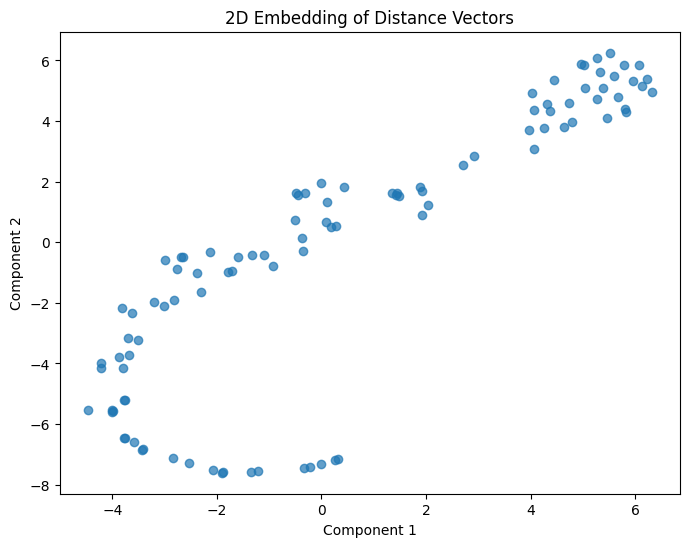

In [ ]:

subset_distance_vectors_array = np.array(fixed_distance_vectors)


embedding = TSNE(n_components=2, random_state=42).fit_transform(subset_distance_vectors_array)


plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.7)
plt.title("2D Embedding of Distance Vectors")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [ ]:
from sklearn.cluster import KMeans


n_clusters = 4  


kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

print("Cluster labels:", cluster_labels)

Cluster labels: [0 1 1 1 2 1 1 0 1 1 1 1 0 2 1 1 3 2 2 1 1 2 3 1 0 1 2 0 1 3 2 3 2 3 2 0 2
 0 2 0 0 1 2 2 2 2 2 0 2 0 1 1 2 3 1 2 2 1 1 0 2 2 0 2 3 1 3 0 2 3 1 2 3 2
 0 1 3 2 3 2 0 1 3 1 3 1 2 0 2 1 3 1 1 3 2 0 1 3 2 0]


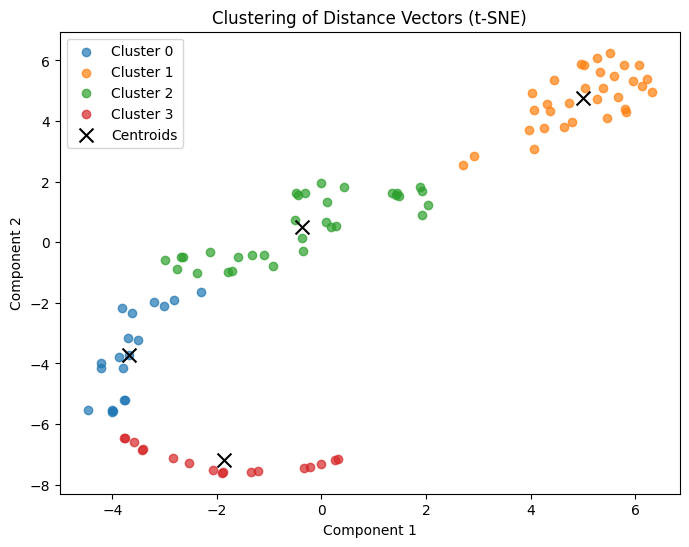

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))


for cluster in range(n_clusters):
    cluster_points = embedding[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", alpha=0.7)


centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', s=100, label="Centroids")

plt.title("Clustering of Distance Vectors (t-SNE)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score


sil_score = silhouette_score(embedding, cluster_labels)
print(f"Silhouette Score: {sil_score:.2f}")


import numpy as np

unique, counts = np.unique(cluster_labels, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

Silhouette Score: 0.57
Cluster sizes: {0: 19, 1: 32, 2: 32, 3: 17}


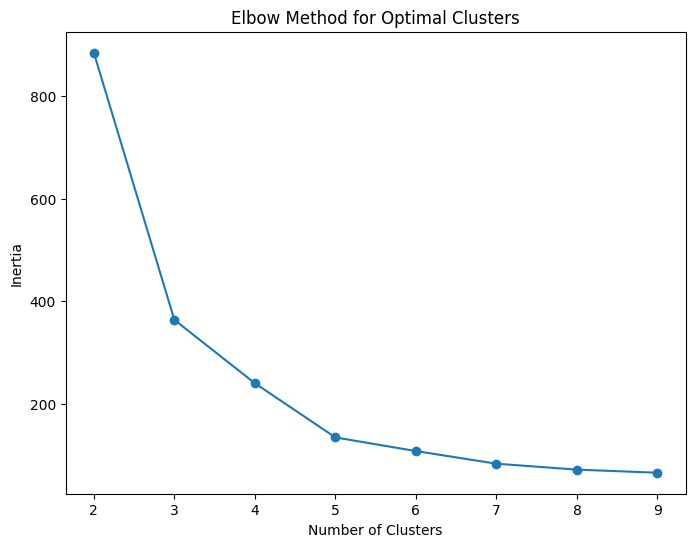

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia_values = []
k_range = range(2, 10)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embedding)
    inertia_values.append(kmeans.inertia_)


plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()